In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib as mpl
import pyarrow.parquet as pq
from pyspark.sql import SparkSession
spark = SparkSession.Builder().appName("Analysis").master("local[12]").config("spark.sql.parquet.int96RebaseModeInRead", "CORRECTED").config("spark.sql.parquet.datetimeRebaseModeInRead", "CORRECTED").config("spark.driver.memory", "20g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/19 19:59:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
originals_full = spark.read.parquet("../test_data.parquet")
originals = spark.read.parquet("../test_data.parquet").select("Id", "Payment_Type", "Notional", "Start_Date", "Term")
df = spark.read.parquet("../CsharpSolution/outcome.parquet").join(originals, "Id")

In [3]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Reset_Frequency: integer (nullable = true)
 |-- Remaining_Notional: float (nullable = true)
 |-- Risk_Indicator: integer (nullable = true)
 |-- Next_Reset_Date: timestamp (nullable = true)
 |-- Date_Of_Payment: timestamp (nullable = true)
 |-- monthly_payment: float (nullable = true)
 |-- Repayment_Payment: float (nullable = true)
 |-- Interest_Payment: float (nullable = true)
 |-- WriteOff: float (nullable = true)
 |-- Payment_Type: string (nullable = true)
 |-- Notional: long (nullable = true)
 |-- Start_Date: timestamp_ntz (nullable = true)
 |-- Term: long (nullable = true)



In [4]:
series = df.groupby(['Date_Of_Payment']).sum().sort('Date_Of_Payment')
series.printSchema()

root
 |-- Date_Of_Payment: timestamp (nullable = true)
 |-- sum(Interest_Rate): double (nullable = true)
 |-- sum(Reset_Frequency): long (nullable = true)
 |-- sum(Remaining_Notional): double (nullable = true)
 |-- sum(Risk_Indicator): long (nullable = true)
 |-- sum(monthly_payment): double (nullable = true)
 |-- sum(Repayment_Payment): double (nullable = true)
 |-- sum(Interest_Payment): double (nullable = true)
 |-- sum(WriteOff): double (nullable = true)
 |-- sum(Notional): long (nullable = true)
 |-- sum(Term): long (nullable = true)



In [5]:
series.show()

+-------------------+------------------+--------------------+-----------------------+-------------------+--------------------+----------------------+---------------------+--------------------+-------------+---------+
|    Date_Of_Payment|sum(Interest_Rate)|sum(Reset_Frequency)|sum(Remaining_Notional)|sum(Risk_Indicator)|sum(monthly_payment)|sum(Repayment_Payment)|sum(Interest_Payment)|       sum(WriteOff)|sum(Notional)|sum(Term)|
+-------------------+------------------+--------------------+-----------------------+-------------------+--------------------+----------------------+---------------------+--------------------+-------------+---------+
|2023-01-01 01:00:00|241730.84574365616|             1746673|   3.153892711805591E10|              35693| 1.187947622880249E8|  1.0099815394258118E8|  6.330972953165889E7| 6.905667547070312E7|  44708491488|  2483865|
|2023-02-01 01:00:00|220468.98126131296|             1596886|   2.879865617931421E10|              30769| 1.087304440763855E8|   9.2

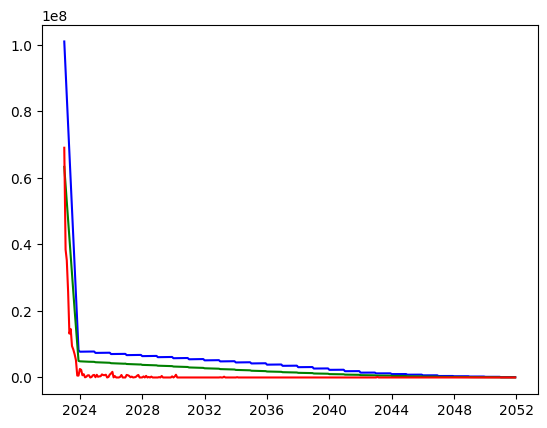

In [6]:
#the code below plots the payment amounts over the date of payment axis
plt.plot(series.select('Date_Of_Payment').collect(), series.select('sum(Repayment_Payment)').collect(), color='blue')
plt.plot(series.select('Date_Of_Payment').collect(), series.select('sum(Interest_Payment)').collect(), color='green')
plt.plot(series.select('Date_Of_Payment').collect(), series.select('sum(WriteOff)').collect(), color='red')
plt.show()

In [12]:
from pyspark.sql.functions import col
wtf = df.filter(col('Risk_Indicator') > 3).filter(col('Date_Of_Payment') < '2023-12-01').groupby(['Date_Of_Payment']).sum().sort('Date_Of_Payment').show()

+-------------------+------------------+--------------------+-----------------------+-------------------+--------------------+----------------------+---------------------+--------------------+-------------+---------+
|    Date_Of_Payment|sum(Interest_Rate)|sum(Reset_Frequency)|sum(Remaining_Notional)|sum(Risk_Indicator)|sum(monthly_payment)|sum(Repayment_Payment)|sum(Interest_Payment)|       sum(WriteOff)|sum(Notional)|sum(Term)|
+-------------------+------------------+--------------------+-----------------------+-------------------+--------------------+----------------------+---------------------+--------------------+-------------+---------+
|2023-01-01 01:00:00| 9612.662591457367|               30217|   4.8030883806933594E8|               7076|   2503525.649810791|    1571340.8579406738|   2231312.2025375366| 6.905667547070312E7|    766230680|    43230|
|2023-02-01 01:00:00| 6795.852157831192|               21783|   3.5047902562597656E8|               5122|   1796568.484588623|    11

In [32]:
originals_full.groupBy('Risk_Indicator').count().orderBy('Risk_Indicator').show()

+--------------+-----+
|Risk_Indicator|count|
+--------------+-----+
|             0|79868|
|             1|10099|
|             2| 5004|
|             3| 3023|
|             4| 2006|
+--------------+-----+



In [41]:
spark.stop()